In [2]:
import cPickle as cp

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import bivariate_normal

import numpy as np
import tensorflow as tf
%matplotlib inline

In [22]:
dim = 2
plot_x_lim = [-6, 6]
plot_y_lim = [-40, 10]
x = np.arange(plot_x_lim[0], plot_x_lim[1], 0.5)
y = np.arange(plot_y_lim[0], plot_y_lim[1], 0.5)
X, Y = np.meshgrid(x, y)

### Learning Model Reparametrizations
#### By Michalis K. Titsias

The idea behind [Learning Model Reparametrizations](https://arxiv.org/abs/1708.01529) is to parametrize a transformation involving the variable of interest and samples from a fixed distribution: $$ \boldsymbol{\theta} = g(\boldsymbol{\xi}; \boldsymbol{\phi}), \ \boldsymbol{\xi} \sim p_{0} $$ where $\boldsymbol{\theta}$ is the model variable, $\boldsymbol{\phi}$ are the transformation parameters, and $p_{0}$ the fixed distribution.  Then MCMC can be run to collect $\boldsymbol{\xi}$ samples, which, ostensibly, is easier than collecting samples of $\boldsymbol{\theta}$ directly.

### Experiment: Collecting samples from the banana distribution
Let's draw data from the classic MCMC test case: the banana distribution...

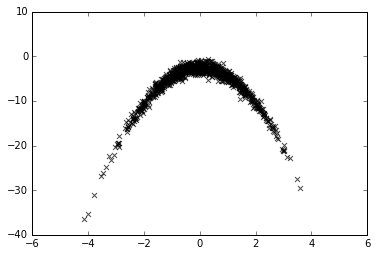

In [23]:
### Make Dataset
N = 1000
data = np.random.normal(size=(N, dim))
z1 = 1.25*data[:,0]
z2 = data[:,1]/1.25 - 2*(z1**2 + 1.25)
data = np.hstack([z1[np.newaxis].T, z2[np.newaxis].T])
np.random.shuffle(data)

plt.scatter(data[:,0], data[:,1], marker='x', s=25, c='k', alpha=.7)

plt.xlim([plot_x_lim[0], plot_x_lim[1]])
plt.ylim([plot_y_lim[0], plot_y_lim[1]])
plt.legend(loc=3)
plt.show()

### Method

Let's define the necessary primatives...

In [27]:
def log_normal_pdf(x, mu, sigma):
    d = mu - x
    d2 = tf.mul(-1., tf.mul(d,d))
    s2 = tf.mul(2., tf.mul(sigma,sigma))
    return tf.reduce_sum(tf.div(d2,s2) - tf.log(tf.mul(sigma, 2.506628)), reduction_indices=1, keep_dims=True)

### Make input variables
X_train = tf.placeholder("float", [None, dim]) # data
noise = tf.placeholder("float", [None, dim]) # fixed distribution

### Make params of transformation
mu = tf.Variable(tf.zeros((1, dim)))
L = tf.Variable(tf.ones((1, dim)))

### Sample from reparametrization
noise = tf.random_normal(shape=(100, dim))
theta = mu + L * noise

### Define Beta Divergence


In [28]:
# Set training params
n_epochs = 500
learning_rate = .1

# get the training operator
train_model = tf.train.AdamOptimizer(learning_rate).minimize(-beta_obj, var_list=[mu, log_sigma])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    
    for epoch_idx in xrange(n_epochs):
        
        # perform update
        _, obj = session.run([train_model, beta_obj], feed_dict={X_train: data})
        if (epoch_idx+1) % 50 == 0:
            print "Epoch %d.  Beta Div. Objective: %.3f" %(epoch_idx+1, obj)
        
    # save the final params
    final_params = {'mu':session.run(mu), 'sigma':session.run(tf.exp(log_sigma))}

Epoch 50.  Beta Div. Objective: -4.452
Epoch 100.  Beta Div. Objective: -3.450
Epoch 150.  Beta Div. Objective: -3.420
Epoch 200.  Beta Div. Objective: -3.428
Epoch 250.  Beta Div. Objective: -3.415
Epoch 300.  Beta Div. Objective: -3.431
Epoch 350.  Beta Div. Objective: -3.428
Epoch 400.  Beta Div. Objective: -3.421
Epoch 450.  Beta Div. Objective: -3.419
Epoch 500.  Beta Div. Objective: -3.432


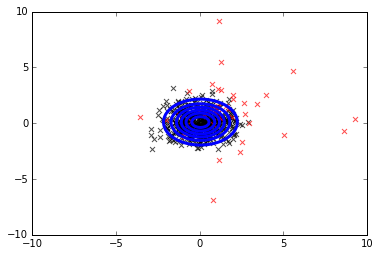

In [29]:
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=final_params['sigma'][0,0], sigmay=final_params['sigma'][0,1], mux=final_params['mu'][0,0], muy=final_params['mu'][0,1], sigmaxy=0.)
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()

We see that the Beta divergence finally allows us to recover the data from the noise, and the model looks like the first one above.